## Consistency

When it comes to choosing the number of clusters and the clustering algorithm, we need to measure **consistency** across sub-samples or folds. Clusters are useful when similar data points get grouped together each time the algorithm is run on different subsets of the same data. However, unlike the cross-validation and test/re-test methods you are familiar with from supervised learning, there's no formal metric for assessing how "similar" clusters are between different data subsets.  

To explore this consistency issue, we'll compare two-, three-, and four-cluster solutions for the Iris dataset. We'll be using k-means algorithm and dividing the data into *two samples* of equal size. Our goal will be to determine which k value optimizes consistency across the two samples.

To compare our solutions, we plot the cluster assignments against two features created by PCA. This is just for visualization purposes – our solution is based on all the features in the data. 

We first import the libraries that we use:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

Next, we load the Iris dataset from `sklearn.datasets` and standardize the features using `StandardScaler`. In order to observe consistency across subsamples, we divide the iris dataset into two random parts using `train_test_split` of the `sklearn.model_selection`. Note that before doing this, we apply PCA to the scaled data since we're using only the first two principal components for visualization purposes. When we divide the data in two, we also divide the principal components accordingly.

In [2]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

Next, we apply k-means for the subsamples and get the predictions. To compare the results of different k-values, we apply k-means by setting k equal to 2, 3 and 4.

In [3]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

Now, we can visualize the results. We graph the clustering results for each of the subsamples, first for the two-cluster solution and then for three- and four-cluster ones. 

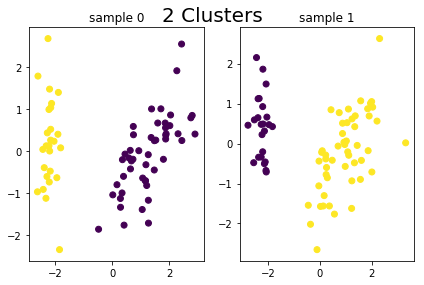

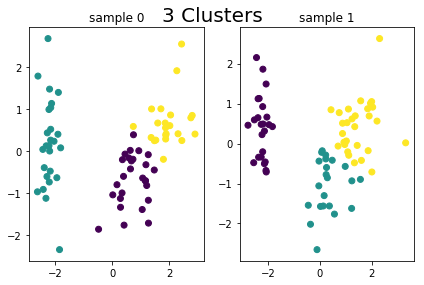

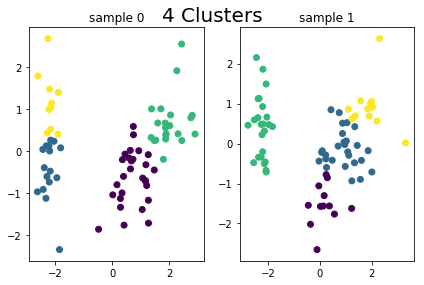

In [4]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Ignoring the specific colors assigned to each cluster, it appears that the four cluster solution doesn't seem to be consistent across the subsamples. For example, in the first subsample, k-means assigns two clusters for the observations at the left side of the chart. However, in the second subsample, it assigns only a single cluster for the observations that reside on the left side of the chart.

On the other hand, the two- and three-cluster solutions yield consistent results in terms of cluster center and cluster shape. Don't forget, however, that we are evaluating this based on the first two principal components from PCA rather than the four-dimensional data actually used by k-means. So the information value of these plots depends on how much information is retained by the PCA. Although, we know that the correct solution should give us three clusters, two-cluster solution also does well in this example. In similar cases like this, we should always look for other measures to determine the consistency of the clustering algorithms.

One possible alternative might be to compute the descriptive statistics of the features for each solution. In a consistent solution, the descriptive statistics for each subsample should have similar scores for each feature.

**Note**: Notice that we ran the experiment above by randomly splitting the original sample into two. However, the randomness in selecting these subsamples may lead us to faulty conclusions. To see this, play with the `random_state` parameter of the `train_test_split` function and check whether our discussion remains valid for all the values of the `random_state` parameter. In these kind of experiments, it's safer to check your results with different parameter values that may affect your samples.

Instead of relying on visualizations, which is somewhat subjective, we should find quantitative ways of evaluating the clustering algorithms. Next, we present some common methods of evaluating clustering solutions first using the ground truths in the data and then without using the ground truths.

## When we have existing labels: contingency tables, RI, and ARI

If we have a "ground truth" – some existing data point group memberships that we can use to check our clusters against – then we can choose the cluster solution that most closely replicates the group memberships we already know. [There are a lot of methods for this](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). We will review two, the basic **contingency table** and the somewhat more complex **Adjusted Rand Index (ARI)**.

#### Contingency tables

A contingency table is a tabulation of the number of observations in each class against the clusters that are assigned to them. We can make use of the Pandas' `crosstab()` function to derive a contingency table. Here is an example of a *contingency table* comparing the cluster memberships for the ground truth and the new cluster solution for our k-means analysis of the Iris data:

In [6]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

pd.crosstab(y, full_pred) 

col_0,0,1,2
row_0,,,
0,0,50,0
1,39,0,11
2,14,0,36


This is somewhat confusing. Pandas' `crosstab()` function returns the cross-tabulation by sorting the cluster names, which are given randomly. Hence, before interpreting this table, we need to organize it a little bit. It seems that the cluster labeled 0 is associated with the class labeled 1, and the cluster labeled 1 is associated with the class labeled 0. So, let's rename the clusters accordingly and print out the contingency table again:

In [7]:
full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred) 

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,39,11
2,0,14,36


Now, we can read it more clearly. It seems that, all of the observations that belong to class 0 are assigned to the same cluster labeled with 0. This is great! However, remember that this class is the one that is linearly separable from the other two. Moreover, our k-means solution mistakenly assigns 14 of the observations that belong to class 1 to cluster 2 and 11 of the observations that belong to class 2 to the cluster 1. So out of 150 observations, 25 of the data points seem to be assigned to the wrong clusters. Well, not horrible, but not *amazing*. 

We could go further and convert it to a ratio of "correctly assigned" datapoints to total datapoints, in order to get a one-number solution we could use to compare across algorithms. However, this basic contingency table solution fails to capture one of the most important things about clustering – that it not only tells us about cluster memberships of individual datapoints, but also about the relationships between datapoint pairs. To do that, let's talk about *Rand Index*:


### The Rand Index

The *Rand Index* compares how pairs of datapoints relate in the ground truth and in the new solution. There are four possible types of pair relationships:

 a. Members of the same cluster in the ground truth, and members of the same cluster in the new solution.  
 b. Members of the same cluster in the ground truth, and members of different clusters in the new solution.  
 c. Members of different clusters in the ground truth, and members of the same cluster in the new solution.  
 d. Members of different clusters in the ground truth, and members of different clusters in the new solution.  

The **Rand Index (RI)** is the ratio of the number of pairs where the ground truth and the new solution agree, over the total number of pairs:

$$RI=\dfrac{a+d}{a+b+c+d}$$

Scores range from 0 to 1, where 1 indicates perfect agreement between the ground truth and the new solution.

Let's calculate the RI by hand:

In [8]:
def rand_index_score(ground_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(predictions), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(ground_truths), 2).sum()
    A = np.c_[(ground_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(ground_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [9]:
rand_index_score(y, full_pred)

0.8330201342281879

The RI score is quite close to 1, which is a good sign for the performance of our k-means solution. 

While RI is nice because it can also be interpreted as the probability that the ground truth and the new solution will agree for any pair, it fails to account for the effect of chance. If we just assigned datapoints to clusters at random (the same number and size of clusters), we'd get an RI considerably higher than 0. The RI produced by random cluster assignment is called the **Expected RI ( or in short $\mathbb{E}(RI)$)**.

### Adjusted Rand Index

The **Adjusted Rand Index (ARI)** applies $\mathbb{E}(RI)$ as a correction factor. With ARI, it is possible to get values less than 0, but 1 still indicates perfect agreement, and 0 indicates perfect randomness.

In a two-cluster solution with an equal number of datapoints in each cluster, just assigning each datapoint to cluster 0 or cluster 1 at random would yield an RI of .5. To correct for the influence of chance and to yield a metric where 0 indicates random labeling and 1 indicates perfect replication of the ground truth, the *Adjusted Rand Index* applies a correction factor based on the expected RI from randomness:

$$ARI=\dfrac{RI-\mathbb{E}(RI)}{max(RI)-\mathbb{E}(RI)}$$

In [10]:
metrics.adjusted_rand_score(y, full_pred)

0.6201351808870379

This tells us that our k-means clustering solution is closer to perfect than to random. Yet, there's still room for improvement. Perhaps a different algorithm would do better. 

**Note**: ARI can be used effectively on all clustering algorithm types, so it is great for comparing different algorithm solutions to one another.

# When we <u>don't</u> have existing labels: similarity

What if we don't have a ground truth? Then we need to use other criteria to evalute clusters, such as similarity. A good cluster is made up of datapoints that are more similar to one another than they are to datapoints in other clusters. One way of computing similarity is the **silhouette coefficient**.

For each datapoint, the *silhouette coefficient* is the difference between the mean distance between that datapoint and all other points in its cluster ($a_i$) and the mean distance between that datapoint and all other points in the *nearest other* cluster ($b_i$), divided by whichever of the two values is highest:  

$$\dfrac{b_i-a_i}{max(b_i,a_i)}$$

The mean of the silhouette coefficients for all datapoints is the silhouette coefficient for that clustering solution on that data. Values range from -1 for very bad clusters to +1 for very dense clusters. However, if clusters employ non-flat geometry, this index will not work well.

The silhouette coefficient is useful for situations where you want to compare the solutions of different clustering algorithms and you don't have a ground truth. Silhouette coefficients can be compared across algorithms, creating a one-number index to represent a clustering solution and compare it against others.

Let's try the index on the Iris data, using the three-cluster solution:

In [11]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.45994823920518635


It appears that our three-cluster solution produces clusters of datapoints that are closer to other datapoints in the cluster than they are to datapoints in the other clusters. This is good. 